In [1]:
import numpy as np

from llama.load_test_data import load_cSAXS_data, load_downsampled_cSAXS_data
from llama.api.options.projections import ProjectionOptions
from llama.api.options.task import AlignmentTaskOptions
from llama.task import LaminographyAlignmentTask
from llama.projections import ComplexProjections, PhaseProjections
import llama.image_processing as ip
from llama.plotting import plotters
import llama.gpu_utils as gutils
from llama.api.options.device import GPUOptions
from llama.api.enums import DeviceType
from llama.api.types import r_type, c_type
from llama.io import save, load
import os

import matplotlib.pyplot as plt
reconstruction_colormap = "bone"

gutils.turn_off_fft_cache()

## First analysis chunk
- Initialization
- Cross correlation alignment
- Mask calculation
- Phase unwrapping

### Initialize data

In [2]:
complex_projections, angles, weights = load_cSAXS_data(load_weights=True)
# complex_projections, angles = load_downsampled_cSAXS_data(8)

In [3]:
projection_options = ProjectionOptions()
complex_projections = ComplexProjections(complex_projections, angles, projection_options)
complex_projections.pin_projections()
complex_projections.masks = weights

task_options = AlignmentTaskOptions()
task = LaminographyAlignmentTask(task_options, complex_projections=complex_projections)

### Get cross-correlation shift

In [4]:
from llama.api.options.device import GPUOptions
from llama.api.enums import DeviceType
task_options.cross_correlation.iterations = 10
task_options.cross_correlation.device.device_type=DeviceType.GPU
n_gpus = 1
task_options.cross_correlation.device.gpu = GPUOptions(
    chunking_enabled=True,
    chunk_length=20,
    n_gpus=n_gpus,
    gpu_indices=[i for i in range(n_gpus)],
)

crop_range = 32 * 30
# crop_range = 128
task_options.cross_correlation.crop_options.enabled = True
task_options.cross_correlation.crop_options.horizontal_range = crop_range
task_options.cross_correlation.crop_options.vertical_range = crop_range

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Cross-correlation shift stored in shift_history


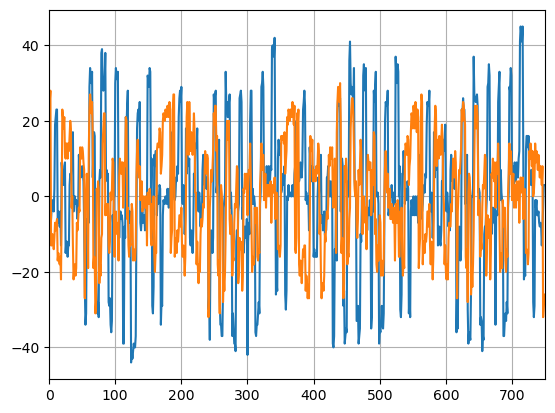

In [5]:
task.get_cross_correlation_shift()
plt.plot(task.complex_projections.shift_manager.staged_shift[np.argsort(angles)])
plt.grid()
plt.xlim([0, len(angles)])
plt.show()
task.complex_projections.apply_staged_shift()

### Get Mask

#### TBD

In [6]:
# task.get_complex_projection_masks(enable_plotting=True)

In [7]:
# plotters.make_image_slider_plot(complex_projections.masks)

#### Blur mask

In [8]:
# This should be absorbed into the mask creation later. Also, in mask creation
# there should be an option to run the algorithm on just a few projections at
# a time.
blurred_masks = task.complex_projections.blur_masks(kernel_sigma=64, use_gpu=True)
complex_projections.masks = blurred_masks

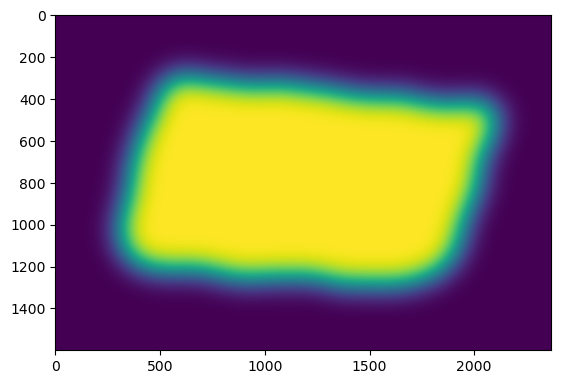

In [9]:
plt.imshow(blurred_masks[0])
plt.show()

### Phase unwrapping

In [10]:
# Update settings
complex_projections.options.phase_unwrap.device.device_type=DeviceType.GPU
n_gpus = 1
complex_projections.options.phase_unwrap.device.gpu = GPUOptions(
    chunking_enabled=True,
    chunk_length=20,
    n_gpus=n_gpus,
    gpu_indices=[i for i in range(n_gpus)],
)

# Pin the array holding outputs
pinned_phase_projections = np.empty_like(complex_projections.data, dtype=r_type)
pinned_phase_projections = gutils.pin_memory(pinned_phase_projections)

In [11]:
# Unwrap the complex projections
task.get_unwrapped_phase(pinned_phase_projections)

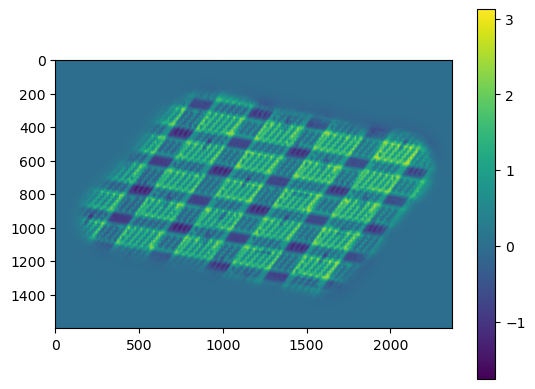

In [12]:
plt.imshow(task.phase_projections.data[10])
plt.colorbar()
plt.show()

### Save results

In [ ]:
folder = "/local/hruth/lamino_demo_intermediate_results/"
commit_hash = "ccef557"
file_path = os.path.join(folder, "task_" + commit_hash + ".h5")
save.save_task(task, file_path, exclude="complex_projections")

## Chunk 2: 
- Load data
- Reconstruction
- Projection matching

### Load data

In [2]:
folder = "/local/hruth/lamino_demo_intermediate_results/"
commit_hash = "3a4bd4a"
file_path = os.path.join(folder, "task_" + commit_hash + ".h5")
task = load.load_task(file_path, exclude="complex_projections")

### Get 3D reconstruction before PMA

In [4]:
task.phase_projections.options.experiment.pixel_size = 2.74671658e-08
task.phase_projections.options.experiment.tilt_angle = 0
task.phase_projections.options.experiment.skew_angle = 0
print(task.phase_projections.reconstructed_object_dimensions)

[2464 2464  256]


In [45]:
# test with proper alignment
rec = task.phase_projections.get_3D_reconstruction()

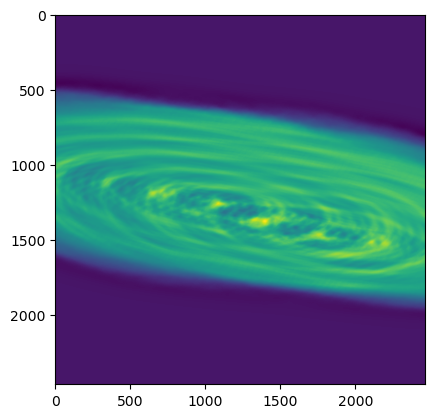

In [46]:
plt.imshow(rec[140])

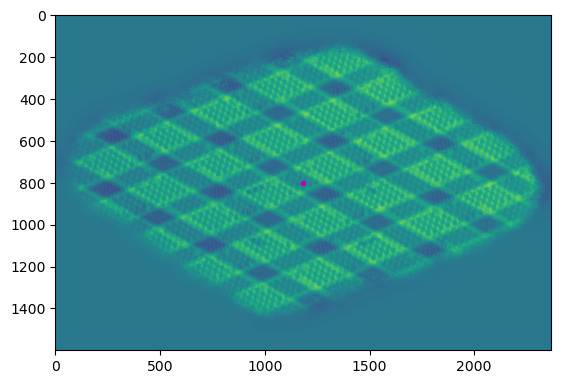

In [34]:
plt.imshow(task.phase_projections.data[30])
plt.plot(
    task.phase_projections.center_of_rotation[1], task.phase_projections.center_of_rotation[0], ".m"
)